<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Laplace_On_Disc/LaplaceOnDisc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
from jax import random
from jax import lax

import jax.numpy as jnp
import numpy as np

import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

from functools import partial

In [133]:
def poisson_kernel(r, theta):
  return ((1 - jnp.power(r, 2)) / 
          (1 - 2 * r * jnp.cos(theta) + jnp.power(r, 2)))

In [134]:
def metroStep(cur, prop, kernel, r, theta):
  k1 = kernel(r, theta-prop[0])
  k2 = kernel(r, theta-cur)
  A = jnp.minimum(1, jnp.divide(k1,k2)) - prop[1]
  Y = jnp.ceil(A)
  out = jnp.multiply(cur, 1-Y) + jnp.multiply(prop[0], Y)
  return out, (out, jnp.array([0.0]))

In [135]:
'''
solve_at_point : Solves the Dirichlet problem for Laplace's equation on a 2D 
disc at polar coordinates (r, theta). Also takes the boundary condition as a
parameter.

Parameters
--------------------
g : the boundary condition as a vectorized function
k : the kernel function of the integral equation as a vectorized function
r : the radius of the polar coordinates as a single number
theta : the angle of the polar coordinates as a single number
n_samples : the number of samples of E[g(X)] where X ~ P(theta - phi)
t : the number of discrete time steps of the Metropolis-Hastings algorithm to
sample from X
key : the key to use for randomness

Returns : the solution to the Dirichlet problem for Laplace's equation on a 2D
disc at the given point with the given boundary condition

Notes
--------------------
Currently, we want to use the Poisson kernel P(theta), so set k as 
poisson_kernel(r)

P(theta) = (1 - r^2) / (1 - 2*r*cos(theta) + r^2)
'''
def solve_at_point(g, k, r, theta, batches, t, key):
  # generate keys
  keys = random.split(key, 2)

  # create proposed states to move to
  proposals = (random.uniform(keys[0], shape=(t, batches, len(r), len(theta))) * 
               2 * jnp.pi)
  
  # create uniform r.v's to determine whether to move to proposed state or not
  U = random.uniform(keys[1], shape=(t-1, batches, len(r), len(theta)))
  
  # create vectors of r and theta
  r = jnp.array(r)
  r = jnp.reshape(r, (1, len(r), 1))
  theta = jnp.array(theta)
  theta = jnp.reshape(theta, (1, 1, len(theta)))

  # run markov chain over time
  metroFunc = partial(metroStep, kernel=poisson_kernel, r=r, theta=theta)
  final, result = lax.scan(metroFunc, proposals[0], (proposals[1:], U))

  # compute E(g(X))
  t_mean = jnp.mean(g(result[0]), axis=0)
  batch_mean = jnp.mean(t_mean, axis=0)
  return batch_mean, result

In [136]:
batches = 100
t = 100000
r = jnp.ones(1) * 0.5
theta = jnp.ones(1) * jnp.pi / 2
key = random.PRNGKey(int(time.time()))
ans, samples = solve_at_point(jnp.sin, poisson_kernel, r, theta, batches, t, key)
ans

DeviceArray([[0.50026727]], dtype=float32)

In [137]:
batch_samples = samples[0].reshape((samples[0].shape[0], samples[0].shape[1]))
batch_samples = jnp.sin(batch_samples)

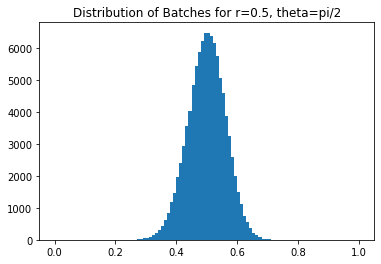

In [138]:
# plot distibution of EV of markov chains
plt.hist(jnp.mean(batch_samples, axis=1), jnp.arange(0, 1.01, 0.01))
plt.title("Distribution of Batches for r=0.5, theta=pi/2")
plt.show()

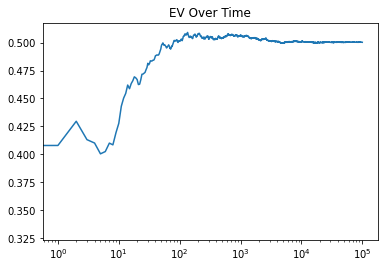

In [139]:
# plot EV of markov chains over time
E_over_time = jnp.cumsum(jnp.mean(batch_samples, axis=1)) / jnp.arange(1, t)
plt.plot(E_over_time)
plt.xscale('log')
plt.title("EV Over Time")
plt.show()

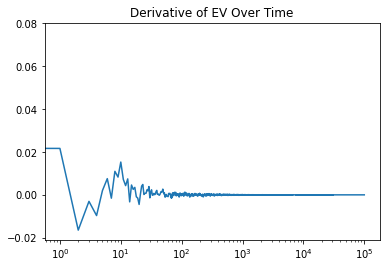

In [140]:
dE_over_time = jnp.diff(E_over_time)
plt.plot(dE_over_time)
plt.xscale('log')
plt.title("Derivative of EV Over Time")
plt.show()

CPU times: user 433 ms, sys: 44.3 ms, total: 477 ms
Wall time: 388 ms


/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


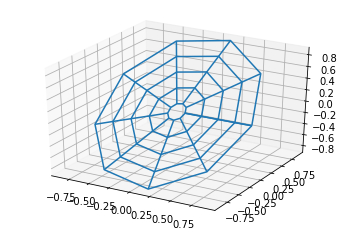

In [141]:
%%time
batches = 100
t = 10000
r = jnp.linspace(0.1,0.9,num=5)
theta = jnp.linspace(0,2*jnp.pi,num=10)
key = random.PRNGKey(0)
ans, samples = solve_at_point(jnp.sin, poisson_kernel, r, theta, batches, t, key)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x = np.outer(r, np.cos(theta))
y = np.outer(r, np.sin(theta))
z = np.array(ans)

#ax.scatter(x,y,z)
ax.plot_wireframe(x, y, z)

